# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

## Собственная реализация SVM

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import numpy as np
import pandas as pd


class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            if y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Собственная реализация Decision Tree

In [30]:
import random
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения


def _mse(x: np.ndarray):
    y_pred = np.mean(x)
    return np.mean(np.square(x - y_pred))


def _mean_accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


def gini(y: np.ndarray):
    classes = np.unique(y)
    prob = []
    for cl in classes:
        prob.append(len(y[y == cl]) / len(y))

    s = 0
    for p in prob:
        s += p * p
    return 1 - s


def entropy(y: np.ndarray):
    classes = np.unique(y)
    prob = []
    for cl in classes:
        prob.append(len(y[y == cl]) / len(y))

    s = 0
    for p in prob:
        s += p * np.log2(p)
    return -s


class Node:
    def __init__(self, left=None, right=None, condition=None, value=None):
        self.child = (left, right) if left is not None else None
        self.feature = condition[0] if condition is not None else None
        self.threshold = condition[1] if condition is not None else None
        self.value = value

    def predict(self, x: pd.DataFrame):
        if self.value is not None:
            if isinstance(self.value, pd.DataFrame):
                print("Value is DATAFRAME")
            return self.value

        left = x[x[self.feature] <= self.threshold]
        right = x[~(x[self.feature] <= self.threshold)]

        left_value = self.child[0].predict(left)
        right_value = self.child[1].predict(right)

        try:
            left_value = left_value["prediction"] if isinstance(left_value, pd.DataFrame) and not left_value.empty else left_value
        except:
            print(left_value)
        try:
            right_value = right_value["prediction"] if isinstance(right_value, pd.DataFrame) and not right_value.empty else right_value
        except:
            print(right_value)

        if len(x[x[self.feature] <= self.threshold].index) > 0:
            x.loc[x[self.feature] <= self.threshold, "prediction"] = left_value
        if len(x[~(x[self.feature] <= self.threshold)].index) > 0:
            x.loc[~(x[self.feature] <= self.threshold), "prediction"] = right_value
        # except:
        #     print("ERROR")
        #     print("x")
        #     print(x)
        #     print("index")
        #     print(x[self.feature] <= self.threshold)
        #     print("END ERROR")
        #     pass
        return x


class DecisionTree:
    def __init__(
            self,
            num_classes,
            ig_threshold,
            max_depth,
            split_method="all",
            choose_method="all",
            criterion="entropy",
            probability=0
    ):
        """
        split method --- method for selecting unique elements from x. Maybe {"all", "mean", "log", "half", "half_mean"}

        choose method --- method for selecting condition for node. Maybe {"all", "random"}

        probability --- influences our belief in the classifier. If 0.5-probability < value < 0.5+probability,
            then we consider that the classifier was unable to determine which class the point belongs to
        """
        self.max_depth = max_depth
        self.min_ig = ig_threshold
        self.split_method = split_method
        self.choose_method = self.information_grow_all if choose_method == "all" else self.information_grow_random
        self.max_iter = 500
        self.loss_func = entropy
        self.probability = probability
        self.classes = list(range(num_classes))

    def fit(self, x: pd.DataFrame, y: np.ndarray | pd.DataFrame):
        if isinstance(y, pd.DataFrame):
            y = y.to_numpy()
        x["target"] = y
        self.root = self._tree_build(x)

    def _calculate_ig(self, mse, left: pd.DataFrame, right: pd.DataFrame, n):
        left_entropy = self.loss_func(left["target"].to_numpy())
        right_entropy = self.loss_func(right["target"].to_numpy())

        ig = mse - (
                (len(left.index) / n) * left_entropy
                + (len(right.index) / n) * right_entropy
        )
        return ig

    def _tree_build(self, x: pd.DataFrame, depth=0):
        curr_split_cond = self.choose_method(x)
        if curr_split_cond == ("", -1) or depth == self.max_depth:
            pred = np.mean(x["target"].to_numpy())
            return Node(value=pred)
        else:
            feature = curr_split_cond[0]
            value = curr_split_cond[1]
            left = x[x[feature] <= value]
            right = x[~(x[feature] <= value)]

            left_node = self._tree_build(left, depth + 1)
            right_node = self._tree_build(right, depth + 1)

            return Node(left=left_node, right=right_node, condition=curr_split_cond)

    def take_unique(self, x: np.ndarray):
        m = np.max(x)
        x = x[x != np.max(x)]
        if len(x) == 1:
            return x
        if len(x) == 0:
            return np.array([m])
        x.sort()
        if self.split_method == "log":
            count = max(np.log2(len(x)), 1)
            step = int(len(x) // count)
            res = list()
            a = 0
            while a < len(x):
                res.append(x[a])
                a += step
            return np.array(res)
        elif self.split_method == "half":
            res = []
            for a in range(0, len(x), 2):
                res.append(x[a])
            return np.array(res)
        elif self.split_method == "half_mean":
            res = []
            for a in range(0, len(x) - 1, 2):
                res.append((x[a] + x[a + 1]) / 2)
            return np.array(res)
        elif self.split_method == "mean":
            x = np.append(x, m)
            res = list()
            a = 0
            while a < len(x) - 1:
                res.append((x[a] + x[a + 1]) / 2)
                a += 1
            return np.array(res)
        else:
            return np.unique(x)

    def information_grow_random(self, root: pd.DataFrame):
        curr_mse = self.loss_func(root["target"].to_numpy())

        features = root.columns.tolist()
        n = len(features)

        max_ig = 0
        best = ("", -1)  # feature and value
        i = 0
        dont_change = 0
        prev = 0
        while i < self.max_iter and dont_change < 5:
            feature = features[random.randint(0, n - 1)]
            if feature == "target":
                continue
            uniq = self.take_unique(root[feature].to_numpy().copy())
            unique_value = uniq[random.randint(0, len(uniq) - 1) if len(uniq) > 1 else 0]
            left: pd.DataFrame = root[root[feature] <= unique_value]
            right: pd.DataFrame = root[~(root[feature] <= unique_value)]

            ig = self._calculate_ig(curr_mse, left, right, len(root.index))
            if prev == ig:
                dont_change += 1
            else:
                dont_change = 0
            prev = ig

            if ig > max_ig and ig > self.min_ig:
                return (feature, unique_value)
        return best

    def information_grow_all(self, root: pd.DataFrame):
        curr_mse = self.loss_func(root["target"].to_numpy())

        features = root.columns.tolist()
        n = len(features)

        max_ig = 0
        best = ("", -1)  # feature and value
        for feature in features:
            if feature == "target":
                continue
            uniq = self.take_unique(root[feature].to_numpy().copy())
            for unique_value in uniq:
                left: pd.DataFrame = root[root[feature] <= unique_value]
                right: pd.DataFrame = root[~(root[feature] <= unique_value)]
                ig = self._calculate_ig(curr_mse, left, right, len(root.index))

                if ig > max_ig and ig > self.min_ig:
                    max_ig = ig
                    best = (feature, unique_value)
        return best

    def predict(self, x: pd.DataFrame):
        temp = self.root.predict(x)
        if not isinstance(temp, pd.DataFrame):
            return np.array([temp] * len(x.index))
        pred = self.root.predict(x)["prediction"].to_numpy()
        for i in range(len(self.classes) - 1):
            pred[(i <= pred) & (pred <= (i + 0.5 - self.probability))] = i
            pred[(pred >= (i + 0.5 + self.probability)) & (pred <= (i + 1))] = i + 1
        return pred

    def score(self, x: pd.DataFrame, y):
        pred = self.predict(x)
        if isinstance(y, pd.DataFrame):
            y = y.to_numpy()
        return _mean_accuracy(pred, y)

## Датасет из условия

Описание датасета:

* `age` --- возраст в годах
* `sex` --- пол (1 = мужской; 0 = женский)
* `cp` --- тип боли в груди
* `trestbps` --- артериальное давление в состоянии покоя (в мм рт. ст. при поступлении в стационар)
* `chol` --- холестерин сыворотки в мг/дл
* `fbs` --- (уровень сахара в крови натощак > 120 мг/дл) (1 = верно; 0 = неверно)
* `restecg` --- результаты электрокардиографии в покое
* `thalach` --- достигнутая максимальная частота сердечных сокращений
* `exang` --- стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
* `oldpeak` --- Депрессия сегмента ST, вызванная физическими упражнениями, по сравнению с отдыхом
* `slope` --- наклон пикового сегмента ST при нагрузке
* `ca` --- количество магистральных сосудов (0-3), окрашенных флюороскопией
* `thal` --- 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект
* `target` --- болен ли человек (1=да, 0=нет)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

In [123]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### EDA

In [124]:
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [125]:
for col in columns:
    print(f"Column: {col}")
    print(df[col].unique().tolist())
    print("*****")

Column: age
[52, 53, 70, 61, 62, 58, 55, 46, 54, 71, 43, 34, 51, 50, 60, 67, 45, 63, 42, 44, 56, 57, 59, 64, 65, 41, 66, 38, 49, 48, 29, 37, 47, 68, 76, 40, 39, 77, 69, 35, 74]
*****
Column: sex
[1, 0]
*****
Column: cp
[0, 1, 2, 3]
*****
Column: trestbps
[125, 140, 145, 148, 138, 100, 114, 160, 120, 122, 112, 132, 118, 128, 124, 106, 104, 135, 130, 136, 180, 129, 150, 178, 146, 117, 152, 154, 170, 134, 174, 144, 108, 123, 110, 142, 126, 192, 115, 94, 200, 165, 102, 105, 155, 172, 164, 156, 101]
*****
Column: chol
[212, 203, 174, 294, 248, 318, 289, 249, 286, 149, 341, 210, 298, 204, 308, 266, 244, 211, 185, 223, 208, 252, 209, 307, 233, 319, 256, 327, 169, 131, 269, 196, 231, 213, 271, 263, 229, 360, 258, 330, 342, 226, 228, 278, 230, 283, 241, 175, 188, 217, 193, 245, 232, 299, 288, 197, 315, 215, 164, 326, 207, 177, 257, 255, 187, 201, 220, 268, 267, 236, 303, 282, 126, 309, 186, 275, 281, 206, 335, 218, 254, 295, 417, 260, 240, 302, 192, 225, 325, 235, 274, 234, 182, 167, 172, 321, 

Пропущенных значений нет, все категориальные признаки уже закодированы числами.

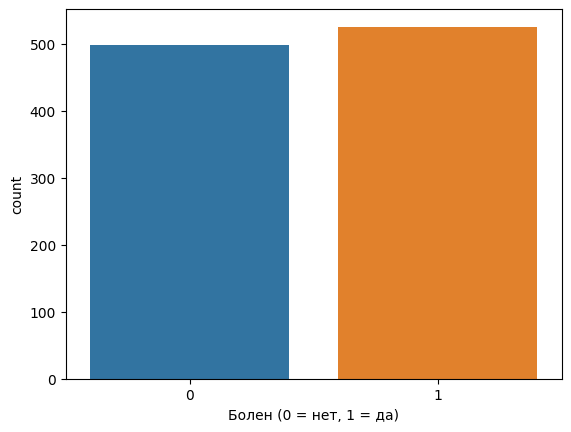

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="target", data=df)
plt.xlabel('Болен (0 = нет, 1 = да)')
plt.show()

Класс, который надо предсказать состоит из равных долей

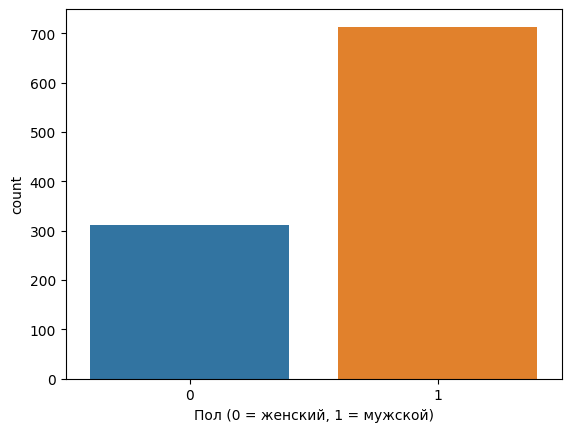

In [127]:
sns.countplot(x="sex", data=df)
plt.xlabel('Пол (0 = женский, 1 = мужской)')
plt.show()

В основном в датасете информация о мужчинах

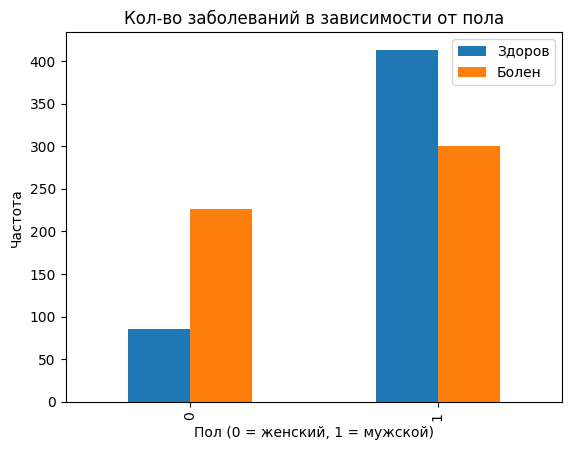

In [128]:
pd.crosstab(df["sex"], df["target"]).plot(kind="bar")
plt.title('Кол-во заболеваний в зависимости от пола')
plt.xlabel('Пол (0 = женский, 1 = мужской)')
plt.ylabel('Частота')
plt.legend(["Здоров", "Болен"])
plt.show()

При этом, больше половины мужчин здоровы, а у женщин подавляющее большинство больны

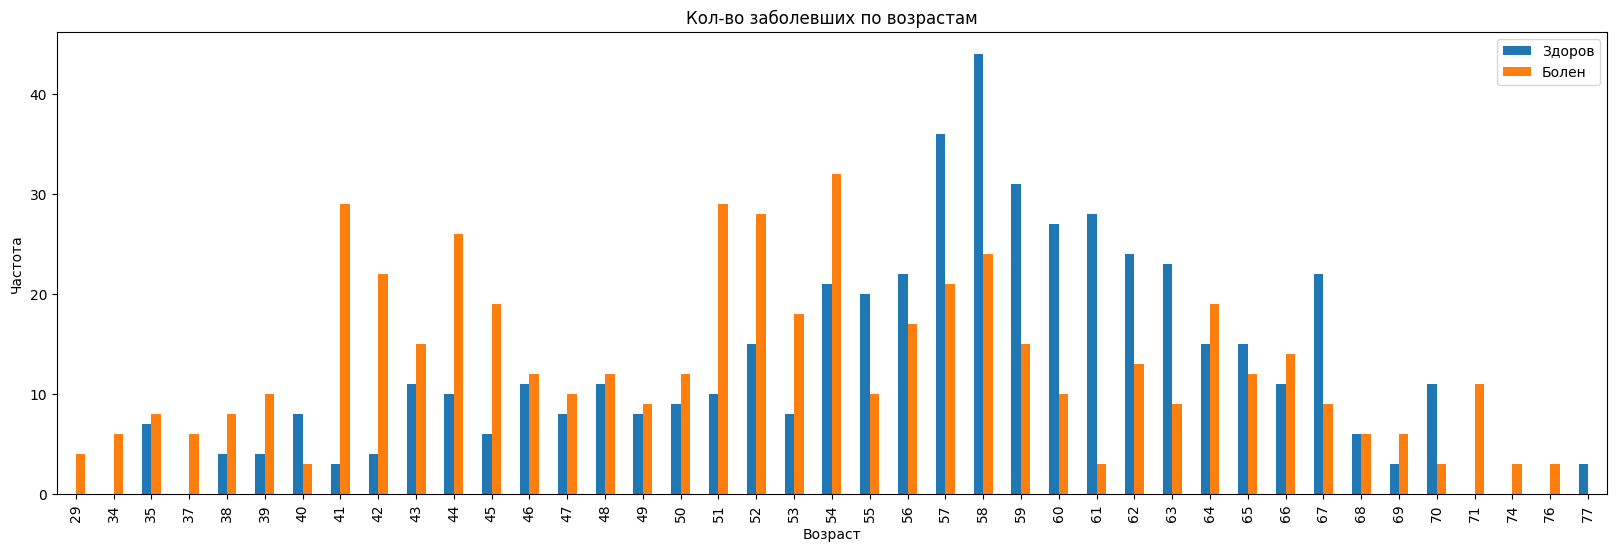

In [129]:
pd.crosstab(df["age"], df["target"]).plot(kind="bar",figsize=(20,6))
plt.title('Кол-во заболевших по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.legend(["Здоров", "Болен"])
plt.show()

До 55 лет поличество больных преобладает надо здоровыми, после 55 здоровых становится больше, чем больных

Text(0.5, 1.0, 'Уровень холестерина у больных и здоровых людей в зависимости от возраста')

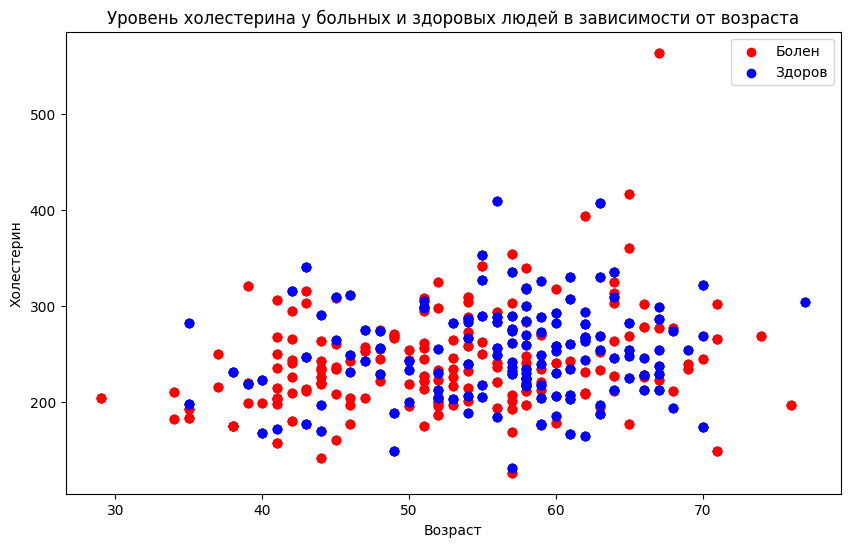

In [130]:
plt.figure(figsize = (10,6))

plt.scatter(df["age"][df["target"] == 1], df["chol"][df["target"] == 1], color = "red")
plt.scatter(df["age"][df["target"] == 0], df["chol"][df["target"] == 0], color = "blue")

plt.xlabel("Возраст")
plt.ylabel("Холестерин")
plt.legend(["Болен", "Здоров"])
plt.title("Уровень холестерина у больных и здоровых людей в зависимости от возраста")

В среднем уровень холестерина одинаковый, что у больных, что у здоровых людей

Text(0.5, 1.0, 'Максимальная частота сердечных сокращений у больных и здоровых людей в зависимости от возраста')

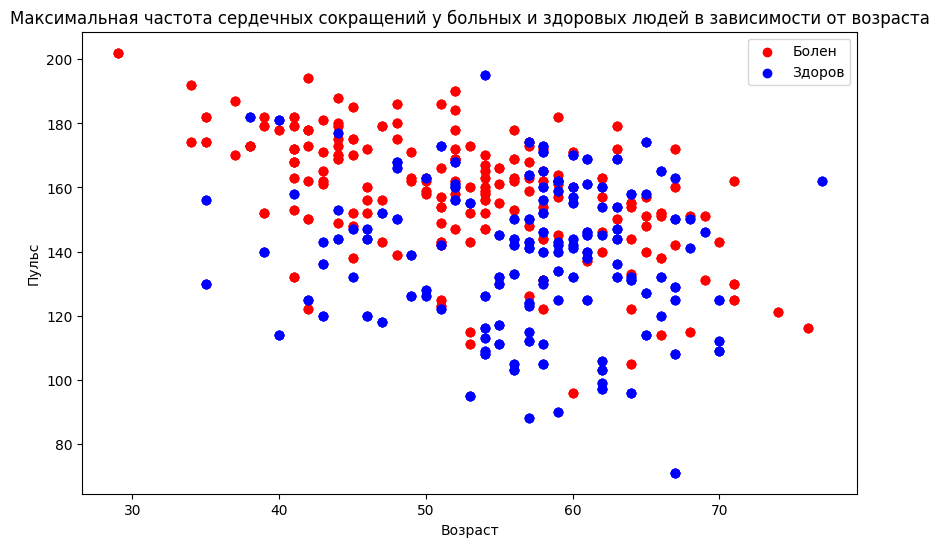

In [131]:
plt.figure(figsize = (10,6))

plt.scatter(df["age"][df["target"] == 1], df["thalach"][df["target"] == 1], color = "red")
plt.scatter(df["age"][df["target"] == 0], df["thalach"][df["target"] == 0], color = "blue")

plt.xlabel("Возраст")
plt.ylabel("Пульс")
plt.legend(["Болен", "Здоров"])
plt.title("Максимальная частота сердечных сокращений у больных и здоровых людей в зависимости от возраста")

Видно, что у больных частота пульса выше, чем у здоровых

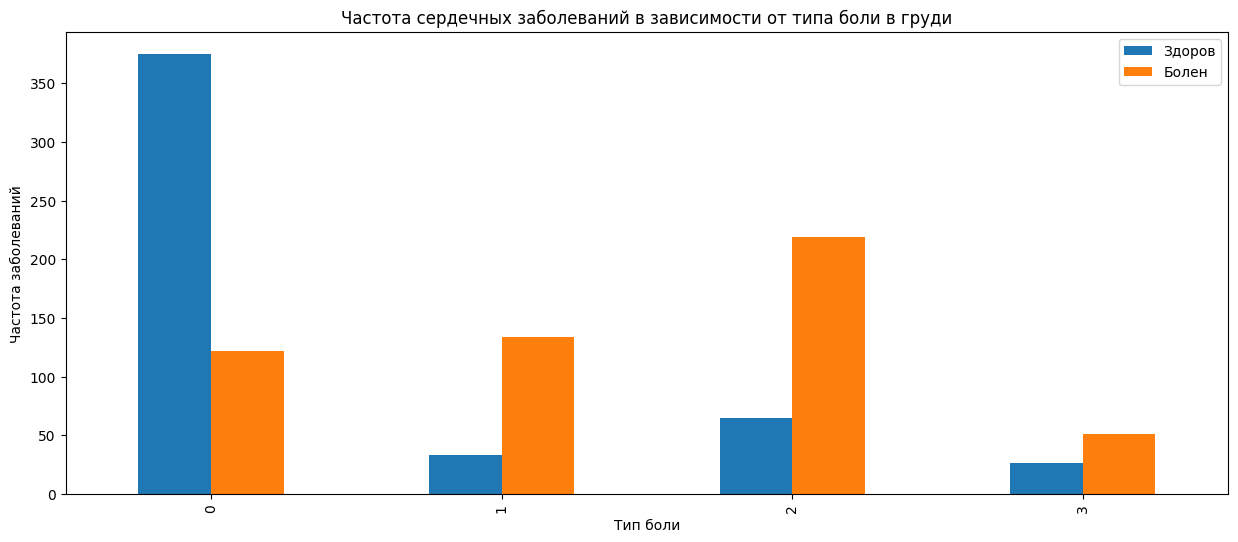

In [132]:
pd.crosstab(df["cp"], df["target"]).plot(kind="bar",figsize=(15,6))
plt.title('Частота сердечных заболеваний в зависимости от типа боли в груди')
plt.xlabel('Тип боли')
plt.legend(["Здоров", "Болен"])
plt.ylabel('Частота заболеваний')
plt.show()

Видно, что люди без болей в груди (тип боли = 0), как и ожидается в основном не болеют, а люди с типом боли 2 и 3 с очень большой вероятностью имеют заболевание

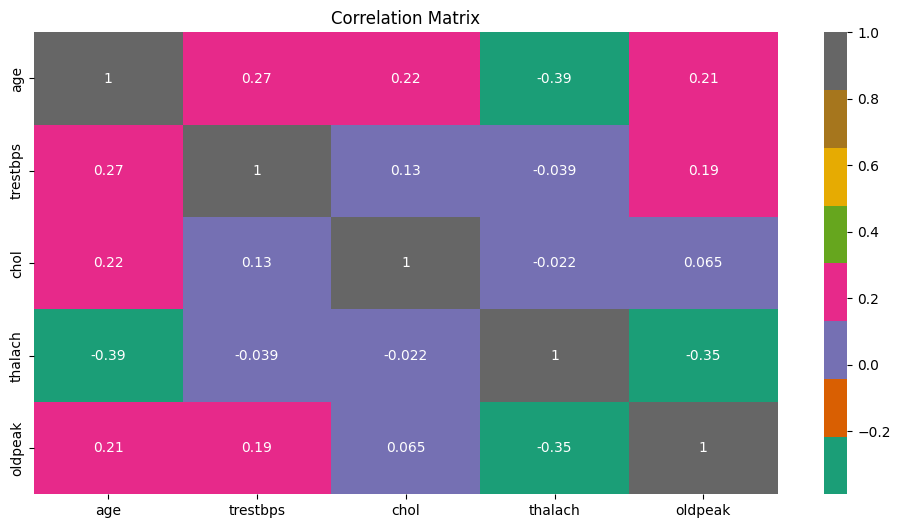

In [133]:
df_corr = df.drop(columns=["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal", "target"]).corr(numeric_only=True)  # категориальные признаки
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, cmap="Dark2")
plt.title("Correlation Matrix")
plt.show()

Сильно выраженной корреляции между признаками нет

### Подготовка данных

#### Масштабирование

In [134]:
from sklearn.preprocessing import StandardScaler

y = df['target']
x_full = df.drop(['target'], axis=1)

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_full), columns=x_full.columns)
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122


#### Подбор наилучших признаков

In [135]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfecv = RFECV(estimator=LogisticRegression())
rfecv.fit(x, y)

best_cols = list(x.columns[rfecv.support_])
print("Достаточное число признаков:", rfecv.n_features_)
print("Самые важные признаки:", *best_cols)

Достаточное число признаков: 12
Самые важные признаки: age sex cp trestbps chol restecg thalach exang oldpeak slope ca thal


In [136]:
x = x[best_cols]
x.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122


#### Разбиение на тренировочные и проверочные данные

In [137]:
from sklearn.model_selection import train_test_split

x_np = x.to_numpy()
y_np = y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Обучение моделей


In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


models = {
    "Logistic Regression": LogisticRegression,
    "SVC": SVC,
    "KNeighbors": KNeighborsClassifier,
    "GaussianNB": GaussianNB,
    "DecisionTreeClassifier": DecisionTreeClassifier,
    "My SVM": SVMClassifier,
    "My Decision Tree": DecisionTree
}

#### Сетка

In [139]:
grid = {
    "Logistic Regression": {
        "C": np.arange(1e-05, 5, 0.1)
    },
    "SVC": {
        "C": [0.1, 0.5, 1, 2],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "degree": [2, 3, 4, 5],
        "gamma": ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1],
        "coef0": [-1, -0.5, 0, 0.5, 1]
    },
    "KNeighbors": {
        "n_neighbors": [1, 3, 5, 7, 9, 11],
        "weights": ['uniform', 'distance'],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    "GaussianNB": {
        "priors": [None, [0.6, 0.4], [0.5, 0.5]],
        "var_smoothing": np.logspace(0, -9, num=100)
    },
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [2, 3, 4, 5, 10, 20],
        "min_samples_split": [2, 4, 5, 10],
        "min_samples_leaf": [1, 2, 4, 6],
        "max_features": [2, 4, 6, 8]
    },
    "My SVM": {
        "learning_rate": [0.01, 0.0001],
        "iter_num": [100, 500, 1000],
        "lmda": [0.01, 0.0001]
    },
    "My Decision Tree": {
        "num_classes": [2],
        "ig_threshold": [0, 0.05, 0.1],
        "max_depth": [3, 15, 30],
        "split_method": ["half_mean", "log"],
        "choose_method": ["all"]
    }
}

#### Подбор гиперпараметров

In [140]:
from itertools import product

best_params = dict()
for model_name in models:
    print(f"Start of selection of hyperparameters for {model_name} model")
    list_of_params = []
    for parameter in grid[model_name]:
        list_of_params.append(grid[model_name][parameter])
    cartesian_product = product(*list_of_params)

    best_params[model_name] = None
    best_acc = 0
    for elem in cartesian_product:
        params = dict()
        for i, parameter in enumerate(grid[model_name]):
            params[parameter] = elem[i]

        model = models[model_name](**params)
        model.fit(x_train.copy(), y_train.copy())
        acc = model.score(x_train.copy(), y_train.copy())
        if acc > best_acc:
            best_params[model_name] = params
            best_acc = acc
    print(f"Best accuracy on train = {best_acc}")
    print(f"Best params is {best_params[model_name]}")
    print("****")


Start of selection of hyperparameters for Logistic Regression model
Best accuracy on train = 0.84375
Best params is {'C': 0.10001}
****
Start of selection of hyperparameters for SVC model
Best accuracy on train = 1.0
Best params is {'C': 0.1, 'kernel': 'poly', 'degree': 3, 'gamma': 1, 'coef0': 0}
****
Start of selection of hyperparameters for KNeighbors model
Best accuracy on train = 1.0
Best params is {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree'}
****
Start of selection of hyperparameters for GaussianNB model
Best accuracy on train = 0.8385416666666666
Best params is {'priors': [0.6, 0.4], 'var_smoothing': 0.2848035868435802}
****
Start of selection of hyperparameters for DecisionTreeClassifier model
Best accuracy on train = 1.0
Best params is {'criterion': 'gini', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 6}
****
Start of selection of hyperparameters for My SVM model
Best accuracy on train = 0.830729166666

#### Обучение

In [141]:
accuracies = dict()
trained_models = dict()
for model_name in models:
    model = models[model_name](**best_params[model_name])
    model.fit(x_train.copy(), y_train.copy())
    acc = model.score(x_test.copy(), y_test.copy())

    print(f"Accuracy for model {model_name} is {acc}")

    accuracies[model_name] = acc
    trained_models[model_name] = model

Accuracy for model Logistic Regression is 0.8715953307392996
Accuracy for model SVC is 0.9883268482490273
Accuracy for model KNeighbors is 0.9883268482490273
Accuracy for model GaussianNB is 0.8521400778210116
Accuracy for model DecisionTreeClassifier is 1.0
Accuracy for model My SVM is 0.8638132295719845
Accuracy for model My Decision Tree is 1.0


### Confusion matrix

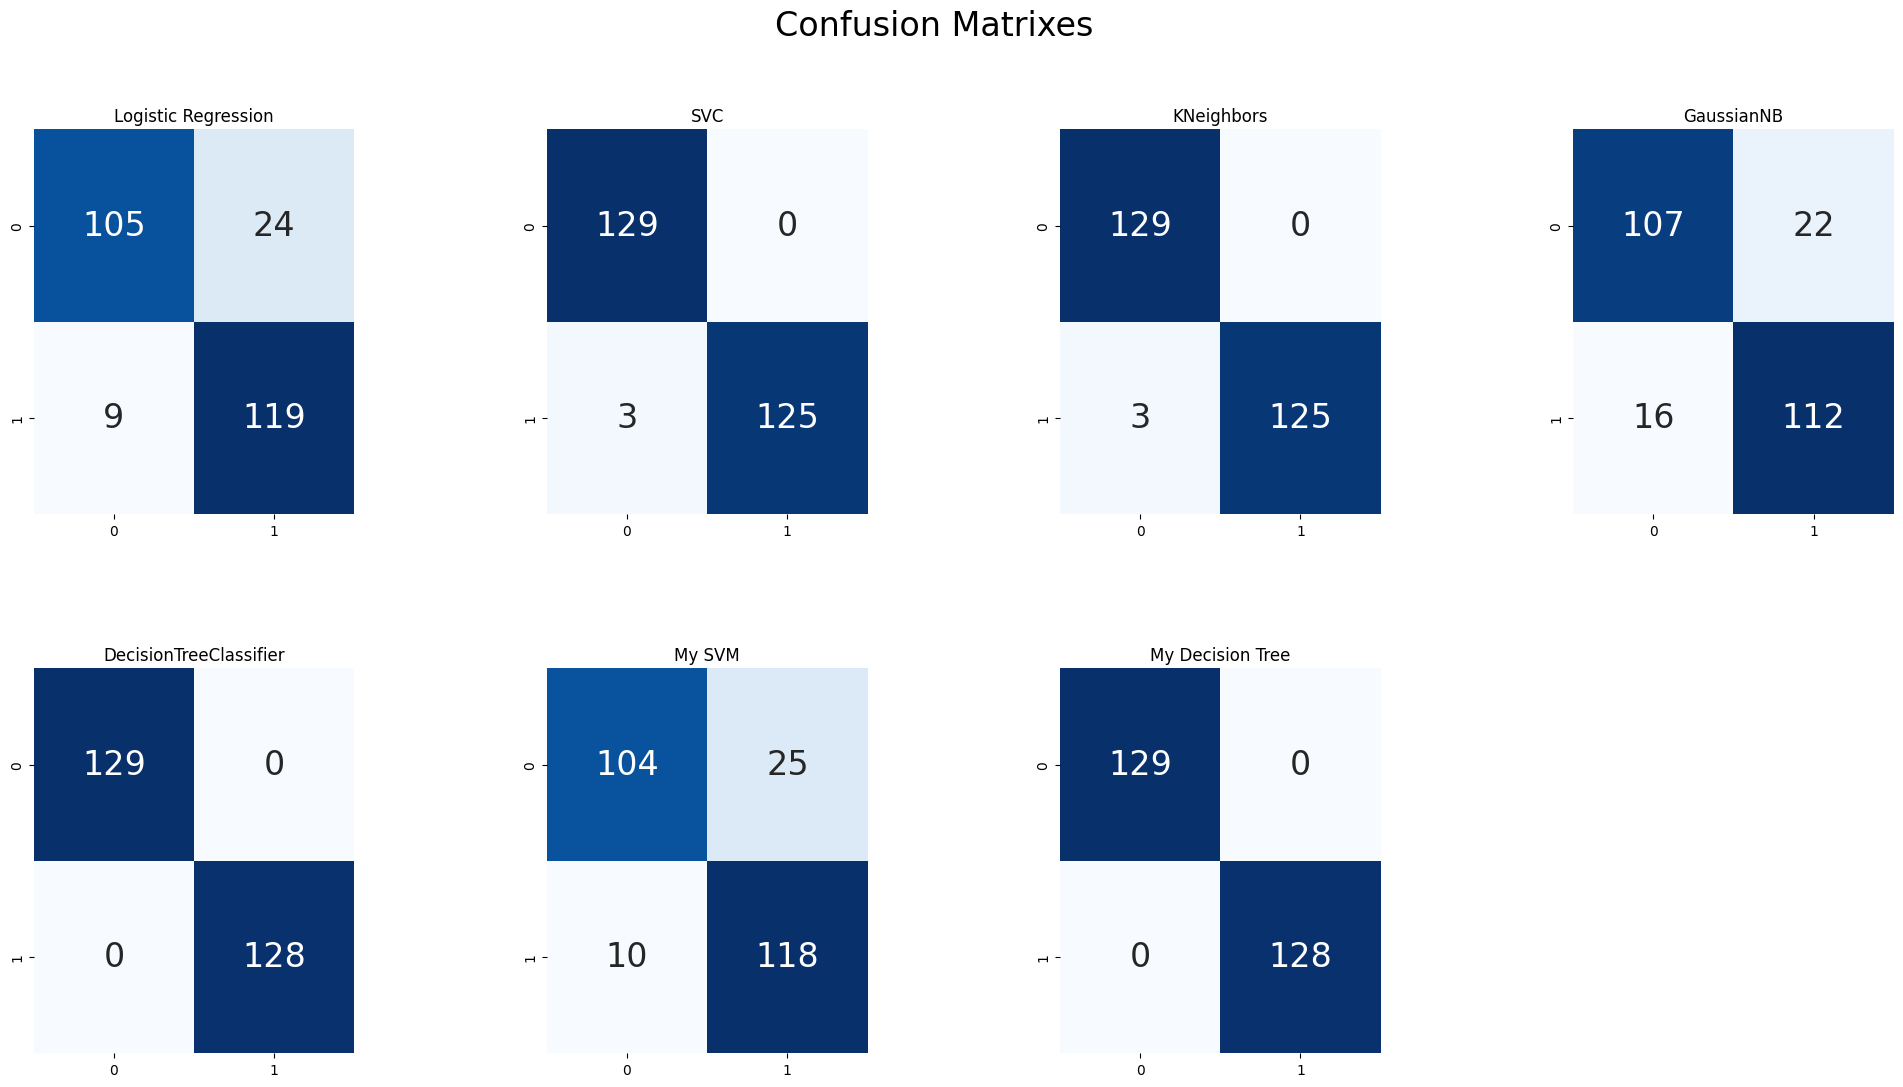

In [142]:
from sklearn.metrics import confusion_matrix

def get_cm(cl):
    return confusion_matrix(y_test, cl.predict(x_test))

plt.figure(figsize=(24, 12))
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)


for idx, model_name in enumerate(trained_models):
    cm = get_cm(trained_models[model_name])
    plt.subplot(2, 4, idx+1)
    plt.title(model_name)
    sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Выводы


- Лучшее качество показали модели Decision Tree, SVC и KNN и собственная реализация Decision Tree
- Собственная реализация SVM уступает по качеству библиотечной, но показывает качество на уровне библиотечных LR и NB


## Датасет не из условия

Был выбран датасет [forest covertype](https://archive.ics.uci.edu/ml/datasets/Covertype), который встроен в scikit-learn и содержит информацию о участках леса размером 30 × 30 м в США.

По имеющимся в датасете данным необходимо разработать решение для задачи прогнозирования типа покрова каждого участка, то есть доминирующих видов деревьев. Существует семь типов покровов, что делает эту проблему мультиклассовой классификации. Каждый образец имеет 54 функции. Некоторые функции являются булевыми индикаторами, а другие — дискретными или непрерывными измерениями.

Таким образом на выбранном датасете предполагается решать задачу классификации: определить тип доминирующего дерева на участке окружающей обстановке и типу почвы.

Нецелевые аттрибуты:
- `Elevation` — Высота в метрах
- `Aspect` — Аспект в азимуте градусов
- `Slope` — Наклон в градусах
- `Horizontal_Distance_To_Hydrology` — Горизонтальное расстояние до ближайших объектов поверхностных вод
- `Vertical_Distance_To_Hydrology` — Расстояние по вертикали до ближайших объектов поверхностных вод
- `Horizontal_Distance_To_Roadways` — Расстояние по горизонтали до ближайшей дороги
- `Hillshade_9am` — Индекс отмывки в 9:00, летнее солнцестояние.
- `Hillshade_Noon` — Индекс отмывки в полдень, летнее солнцестояние
- `Hillshade_3pm` — Индекс отмывки в 15:00, летнее солнцестояние.
- `Horizontal_Distance_To_Fire_Points` — Расстояние по горизонтали до ближайших точек возгорания лесных пожаров
- `Wilderness_Area` — Обозначение области дикой природы (4 типа)
- `Soil_Type` — Обозначение типа почвы (40 типов)
    

Целевой аттрибут:
- `Cover_Type` — Обозначение типа лесного покрова.

In [1]:
from sklearn.datasets import fetch_covtype

dataset = fetch_covtype(as_frame=True)
df = dataset.frame
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [2]:
# приведём классы cover_type от интервала [1..7] в интервал [0..6]

df['Cover_Type'] -= 1

In [3]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,1.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

В данных нет пропущенных значений, следовательно, их корректировка не требуются.

### EDA

#### Распределение данных

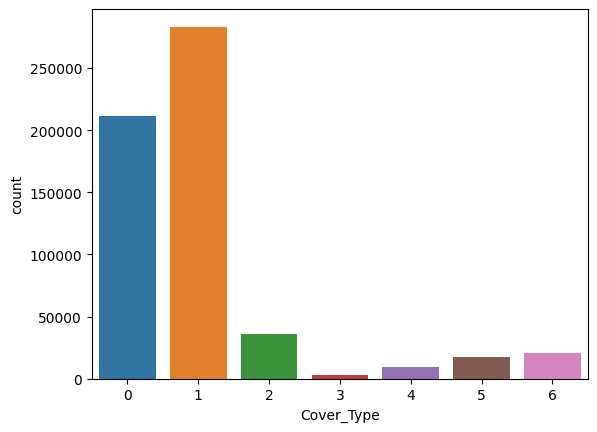

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="Cover_Type", data=df)
plt.show()

array([[<Axes: title={'center': 'Elevation'}>,
        <Axes: title={'center': 'Aspect'}>,
        <Axes: title={'center': 'Slope'}>,
        <Axes: title={'center': 'Horizontal_Distance_To_Hydrology'}>,
        <Axes: title={'center': 'Vertical_Distance_To_Hydrology'}>],
       [<Axes: title={'center': 'Horizontal_Distance_To_Roadways'}>,
        <Axes: title={'center': 'Hillshade_9am'}>,
        <Axes: title={'center': 'Hillshade_Noon'}>,
        <Axes: title={'center': 'Hillshade_3pm'}>,
        <Axes: title={'center': 'Horizontal_Distance_To_Fire_Points'}>]],
      dtype=object)

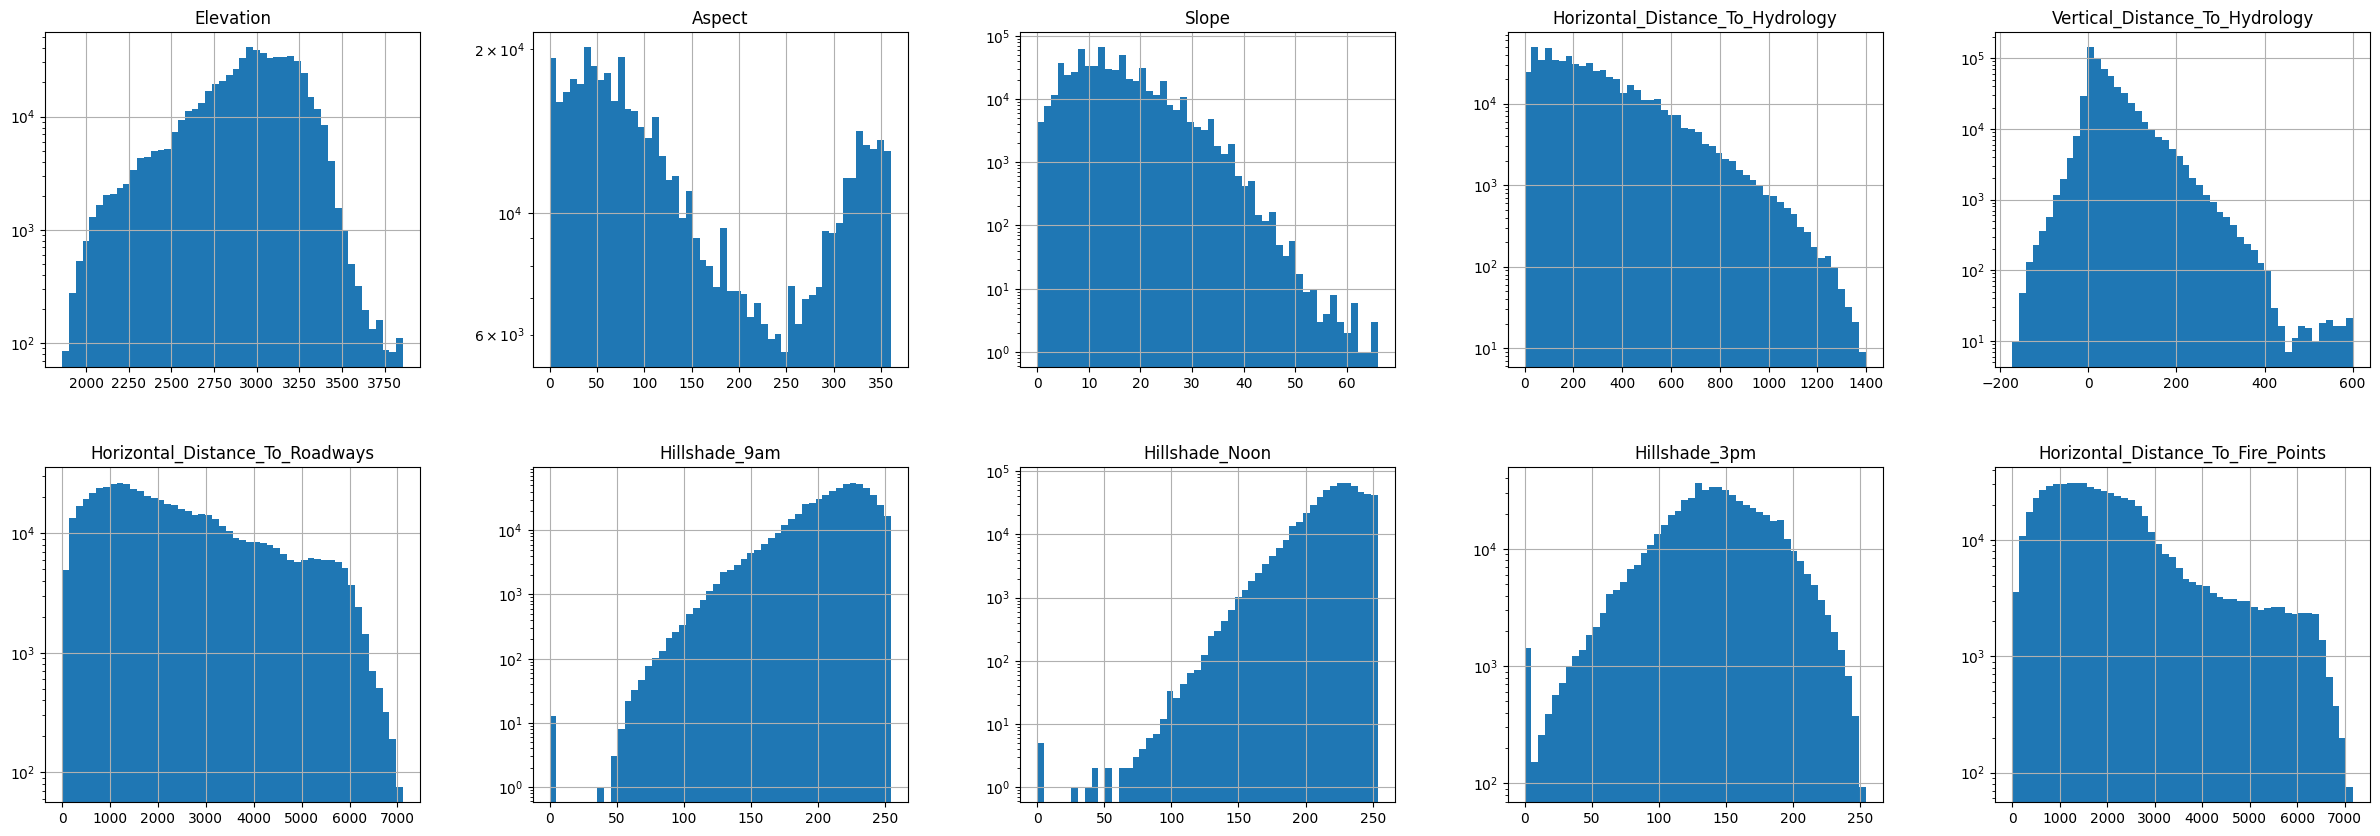

In [7]:
soil_columns = [f"Soil_Type_{i}" for i in range(40)]
wild_columns = [f"Wilderness_Area_{i}" for i in range(4)]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,10))
df.drop(columns=soil_columns + wild_columns + ["Cover_Type"]).hist(ax=axes, bins=50, log=True)

У всех не бинарных атрибутов вполне плавное распределение, без всплесков, исключение составляет отмывка ("hillshade").


Значения аттрибутов отмывки --- HillShade_9am, HillShade_Noon и HillShade_3pm почти отсутствуют у минимума. Значения, которыми снизу ограничивается 99% значений этих аттрибутов (и их сравнения с минимумами для демонстрации скачка), приведены ниже.

In [8]:
df.describe(percentiles=[.01, .99])[["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]].loc[["1%", "99%", "min", "max"]]

,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
1%,127.0,162.0,41.0
99%,252.0,254.0,226.0
min,0.0,0.0,0.0
max,254.0,254.0,254.0


<Axes: xlabel='Cover_Type', ylabel='count'>

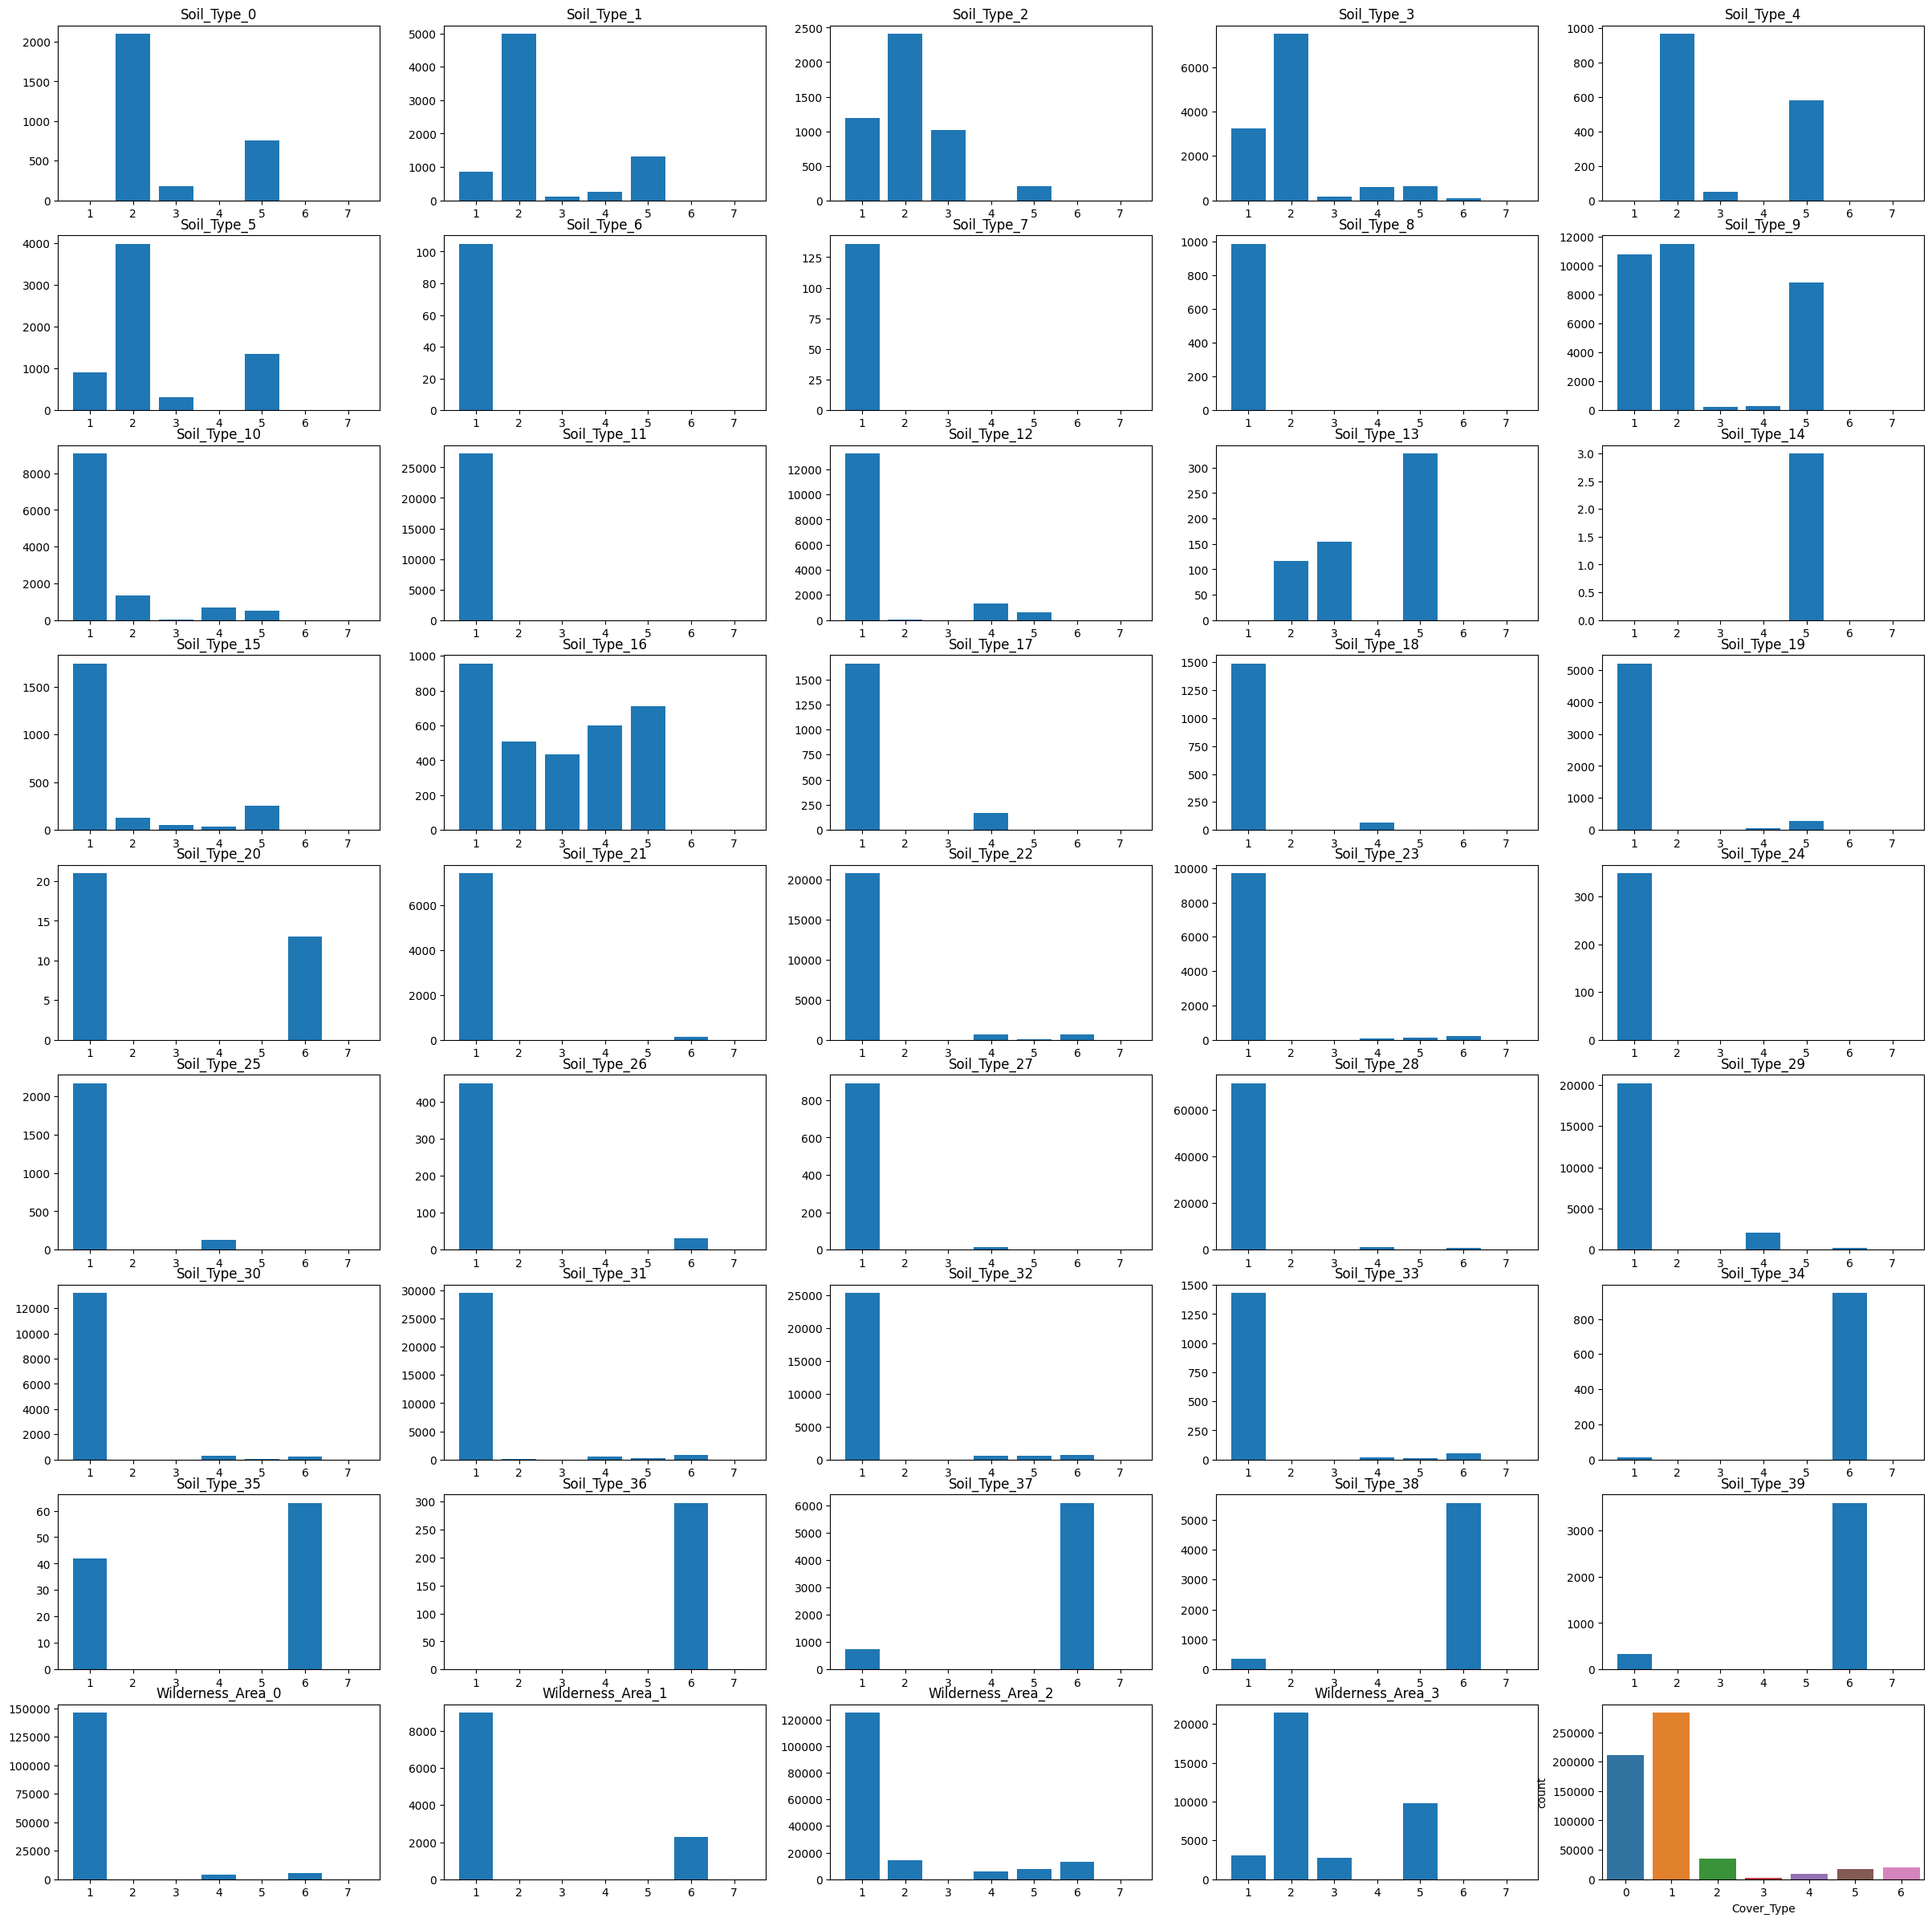

In [9]:
from pandas import DataFrame
import seaborn as sns

row = 9
col = 5
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(30,30))

# Количество деревьев по типу
num_of_ct = 7
for i, soil in enumerate(soil_columns):
    chouse = df.value_counts(subset=["Cover_Type", soil]).reset_index()

    chouse = chouse[(chouse != 0).all(1)].reset_index()
    chouse = chouse.drop(columns=[soil])

    expanded = DataFrame({"Cover_Type": [1, 2, 3, 4, 5, 6, 7], 0: [0, 0, 0, 0, 0, 0, 0]})
    temp = expanded.where(expanded["Cover_Type"].isin(chouse["Cover_Type"]) == False).dropna()

    suppl = chouse.merge(temp, on=['Cover_Type', 0],
                   how='outer', indicator=True)

    axes[i // col, i % col].bar(suppl["Cover_Type"], suppl[0], width=0.8)
    axes[i // col, i % col].title.set_text(soil)

for i, wild in enumerate(wild_columns):
    offset = len(soil_columns) + i
    chouse = df.value_counts(subset=["Cover_Type", wild]).reset_index()

    chouse = chouse[(chouse != 0).all(1)].reset_index()
    chouse = chouse.drop(columns=[wild])
    expanded = DataFrame({"Cover_Type": [1, 2, 3, 4, 5, 6, 7], 0: [0, 0, 0, 0, 0, 0, 0]})
    temp = expanded.where(expanded["Cover_Type"].isin(chouse["Cover_Type"]) == False).dropna()
    suppl = chouse.merge(temp, on=['Cover_Type', 0],
                   how='outer', indicator=True)
    axes[offset // col, offset % col].bar(suppl["Cover_Type"], suppl[0], width=0.8)
    axes[offset // col, offset % col].title.set_text(wild)
sns.countplot(data=df, x="Cover_Type", ax=axes[row - 1, col - 1])

In [10]:
# На данные типы почвы приходится меньше процента деревьев

print("Soil_Type_14", df["Soil_Type_14"].mean())
print("Soil_Type_24", df["Soil_Type_24"].mean())
print("Soil_Type_26", df["Soil_Type_26"].mean())
print("Soil_Type_27", df["Soil_Type_27"].mean())
print("Soil_Type_35", df["Soil_Type_35"].mean())
print("Soil_Type_36", df["Soil_Type_36"].mean())


Soil_Type_14 5.163404542419089e-06
Soil_Type_24 0.0008158179177022161
Soil_Type_26 0.0018691524443557104
Soil_Type_27 0.0016281935657094862
Soil_Type_35 0.00020481504684929054
Soil_Type_36 0.0005128981845469629


In [11]:
soil_indices = dict()
for i, soil in enumerate(soil_columns):
    soil_indices[soil] = df[df[soil] == 1].index.tolist()

In [12]:
df["Soil_Type"] = 0
for i, soil in enumerate(soil_columns):
    df.loc[soil_indices[soil], "Soil_Type"] = i

In [13]:
wild_indices = dict()
for i, wild in enumerate(wild_columns):
    wild_indices[wild] = df[df[wild] == 1].index.tolist()

df["Wilderness_Area"] = 0
for i, wild in enumerate(wild_columns):
    df.loc[wild_indices[wild], "Wilderness_Area"] = i

In [14]:
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Soil_Type,Wilderness_Area
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,28,0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,28,0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11,0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,29,0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,2
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,2
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,2
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,2


In [15]:
df = df.drop(columns=soil_columns + wild_columns)


Среди типов почвы заметно выделяется Soil_Type с 28 по 32 и 22, а также 9. С другой стороны 14, 24 и 35 типы почвы содержат крайне мало данных и возможно их можно опустить. Остановимся на том, что объединим все типы почвы в один столбец с 40 классами и все типы дикости природы в один столбец с 4 классами.

Среди дикости природы видно, что половина деревьев типа 1 и 2 приходится на нулевой тип и другая половина на второй тип, а на третий тип приходится основное количество деревьев 6-ого типа.

При этом в датасете в основном хранится информация про деревья первого и второго типа, меньше всего информации про деревья 4 типа.

Таким образом можно сделать следующие выводы:
- **Деревья 1 и 2 типа** -- скорее всего тип дикости природы 0 или 2
- **Деревья 3 типа** -- скорее всего тип дикости природы 2 или 3
- **Деревья 4 типа** -- скорее всего тип дикости природы 3
- **Деревья 5 типа** -- скорее всего тип дикости природы 0 или 2
- **Деревья 6 типа** -- скорее всего тип дикости природы 2 или 3
- **Деревья 7 типа** -- скорее всего тип дикости природы 2, возможно 0 или 1


#### Корреляция аттрибутов

Попробуем проследить зависимости не бинарных аттрибутов.



<Axes: >

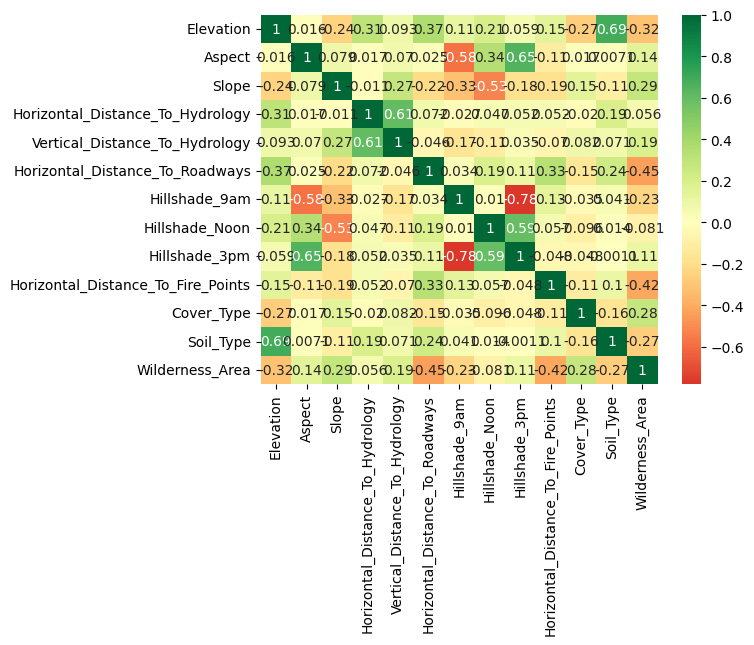

In [16]:
import seaborn as sns

sns.heatmap(df.corr(), center=0, annot=True, cmap="RdYlGn")

Заметим, что существуют сильные корреляции между отмывками, наклоном и аспектом. Причём отмывки коррелируют очень сильно (что логично) и отмывки коррелируют сильно с наклоном и аспектом, в то время как аспект с наклоном коррелируют слабо. Таким образом можно оставить только аспект и наклон.

Также сильно коррелируют вертикальная и горизонтальная дистанции до водяного слоя, однако исходя из здравого смысла, давайте оставим оба аттрибута.

И присутствует незначительная отрицательная корреляция между высотой и типом покрова.

In [17]:
df = df.drop(columns=["Hillshade_9am", "Hillshade_3pm", "Hillshade_Noon", "Horizontal_Distance_To_Hydrology"])

In [18]:
df

,Elevation,Aspect,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,2596.0,51.0,3.0,0.0,510.0,6279.0,4,28,0
1,2590.0,56.0,2.0,-6.0,390.0,6225.0,4,28,0
2,2804.0,139.0,9.0,65.0,3180.0,6121.0,1,11,0
3,2785.0,155.0,18.0,118.0,3090.0,6211.0,1,29,0
4,2595.0,45.0,2.0,-1.0,391.0,6172.0,4,28,0
...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,17.0,108.0,837.0,2,1,2
581008,2391.0,152.0,19.0,12.0,95.0,845.0,2,1,2
581009,2386.0,159.0,17.0,7.0,90.0,854.0,2,1,2
581010,2384.0,170.0,15.0,5.0,90.0,864.0,2,1,2


<Axes: >

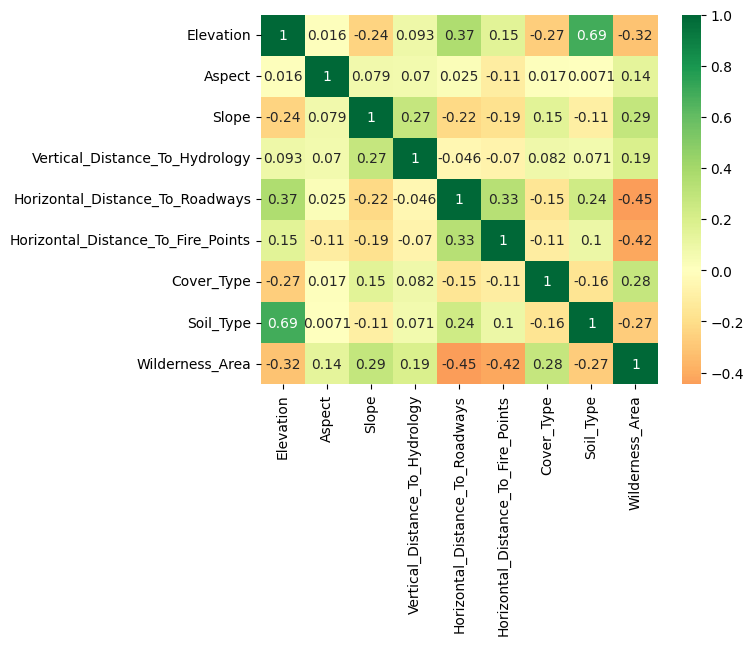

In [19]:
sns.heatmap(df.corr(), center=0, annot=True, cmap="RdYlGn")

Таким образом, в ходе разведочного анализа было принято решение отказаться от 3 аттрибутов и объединить типы почвы в один столбец для уменьшения количества аттрибутов.

#### Заметки

На серверах, предоставляемых Google ~600 000 строк обрабатывается крайне долго (MyBaggingClassifier считает 40 минут при переборе 3, 5 и 8 деревьев)

Поэтому было принято решение выкинуть 560 000 случайных строк из датасета. За счёт выкидывания именно случайных строк, распределение типов покрова должно сохраниться.

In [20]:
from numpy.random import default_rng

drop_indices = default_rng().choice(df.index, size=560_000, replace=False)
df = df.drop(index=drop_indices)


In [21]:
df = df.reset_index()
df = df.drop(columns=["index"])
df

,Elevation,Aspect,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,2840.0,153.0,26.0,42.0,4613.0,4833.0,1,29,0
1,2746.0,143.0,16.0,22.0,2440.0,6597.0,1,11,0
2,2788.0,13.0,16.0,8.0,4126.0,5396.0,1,28,0
3,2909.0,57.0,16.0,23.0,5502.0,4084.0,1,28,0
4,3070.0,0.0,11.0,-6.0,6890.0,2858.0,1,28,0
...,...,...,...,...,...,...,...,...,...
21007,2464.0,157.0,30.0,78.0,210.0,904.0,2,3,2
21008,2442.0,154.0,26.0,63.0,201.0,918.0,2,3,2
21009,2575.0,120.0,28.0,167.0,379.0,1318.0,2,3,2
21010,2464.0,172.0,26.0,72.0,256.0,883.0,2,1,2


### Подготовка данных

#### Масштабирование

In [24]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

y = df['Cover_Type']
x_full = df.drop(['Cover_Type'], axis=1)

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_full), columns=x_full.columns)
x.head()

,Elevation,Aspect,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness_Area
0,-0.428546,-0.028743,1.599551,-0.083941,1.446408,2.146546,0.589878,-1.046233
1,-0.762971,-0.117976,0.260266,-0.420515,0.056816,3.472687,-1.300074,-1.046233
2,-0.613547,-1.278010,0.260266,-0.656116,1.134981,2.569798,0.484880,-1.046233
3,-0.183063,-0.885383,0.260266,-0.403686,2.014907,1.583462,0.484880,-1.046233
4,0.389729,-1.394014,-0.409377,-0.891717,2.902507,0.661779,0.484880,-1.046233


#### Подбор наилучших признаков

In [25]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfecv = RFECV(estimator=LogisticRegression())
rfecv.fit(x, y)

best_cols = list(x.columns[rfecv.support_])
print("Достаточное число признаков:", rfecv.n_features_)
print("Самые важные признаки:", *best_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Достаточное число признаков: 2
Самые важные признаки: Elevation Soil_Type


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
x = x[best_cols]
x.head()

,Elevation,Soil_Type
0,-0.428546,0.589878
1,-0.762971,-1.300074
2,-0.613547,0.484880
3,-0.183063,0.484880
4,0.389729,0.484880


#### Разбиение на тренировочные и проверочные данные

In [27]:
from sklearn.model_selection import train_test_split

x_np = x.to_numpy()
y_np = y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Обучение моделей


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


models = {
    "Logistic Regression": LogisticRegression,
    "SVC": SVC,
    "KNeighbors": KNeighborsClassifier,
    "GaussianNB": GaussianNB,
    "DecisionTreeClassifier": DecisionTreeClassifier,
    "My SVM": SVMClassifier,
    "My Decision Tree": DecisionTree
}

#### Сетка

In [32]:
grid = {
    "Logistic Regression": {
        "C": np.arange(1e-05, 5, 0.1)
    },
    "SVC": {
        "C": [0.1, 0.5, 1, 2],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "degree": [3, 4],
        "gamma": ["scale", "auto", 0.0001, 0.5],
        "coef0": [-1, 0, 1]
    },
    "KNeighbors": {
        "n_neighbors": [1, 3, 5, 7, 9, 11],
        "weights": ['uniform', 'distance'],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    "GaussianNB": {
        "priors": [None, [0.37, 0.45, 0.08, 0.01, 0.03, 0.03, 0.03], [0.15, 0.15, 0.14, 0.14, 0.14, 0.14, 0.14]],
        "var_smoothing": np.logspace(0, -9, num=100)
    },
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [2, 3, 5, 10, 20, 40],
        "min_samples_split": [2, 5, 10, 15],
        "min_samples_leaf": [1, 3, 5, 10],
        "max_features": [2, 5, 8, 12]
    },
    "My SVM": {
        "learning_rate": [0.01, 0.0001],
        "iter_num": [100, 500, 1000],
        "lmda": [0.01, 0.0001]
    },
    "My Decision Tree": {
        "num_classes": [7],
        "ig_threshold": [0, 0.05, 0.1],
        "max_depth": [3, 15, 40],
        "split_method": ["half_mean", "log"],
        "choose_method": ["all"]
    }
}

#### Подбор гиперпараметров

In [33]:
# т.к. обучение на большом датасете занимает много времени, для подбора гиперпараметров был выбран урезанный датасет
train_df = x_train.copy()
train_df['Cover_Type'] = y_train.to_numpy()
drop_indices = default_rng().choice(train_df.index, size=len(train_df.index) - 5000, replace=False)

train_df_for_grid_search = train_df.drop(index=drop_indices)

x_train_for_grid_search = train_df_for_grid_search.drop(columns=['Cover_Type'])
y_train_for_grid_search = train_df_for_grid_search['Cover_Type']

In [34]:
from itertools import product

best_params = dict()
for model_name in models:
    print(f"Start of selection of hyperparameters for {model_name} model")
    list_of_params = []
    for parameter in grid[model_name]:
        list_of_params.append(grid[model_name][parameter])
    cartesian_product = product(*list_of_params)

    best_params[model_name] = None
    best_acc = 0
    for j, elem in enumerate(cartesian_product):
        params = dict()
        for i, parameter in enumerate(grid[model_name]):
            params[parameter] = elem[i]

        model = models[model_name](**params)
        model.fit(x_train_for_grid_search.copy(), y_train_for_grid_search.copy())
        acc = model.score(x_train_for_grid_search.copy(), y_train_for_grid_search.copy())
        if j % 10 == 0:
            print(str(j) + "...", end='')
        if acc > best_acc:
            best_params[model_name] = params
            best_acc = acc
    print()
    print(f"Best accuracy on train = {best_acc}")
    print(f"Best params is {best_params[model_name]}")
    print("****")


Start of selection of hyperparameters for Logistic Regression model
0...10...20...30...40...
Best accuracy on train = 0.6848
Best params is {'C': 3.60001}
****
Start of selection of hyperparameters for SVC model
0...10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...300...310...320...330...340...350...360...370...380...
Best accuracy on train = 0.6966
Best params is {'C': 0.1, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'coef0': 1}
****
Start of selection of hyperparameters for KNeighbors model
0...10...20...30...
Best accuracy on train = 0.9088
Best params is {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute'}
****
Start of selection of hyperparameters for GaussianNB model
0...10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...
Best accuracy on 

#### Обучение

In [35]:
accuracies = dict()
trained_models = dict()
for model_name in models:
    model = models[model_name](**best_params[model_name])
    model.fit(x_train.copy(), y_train.copy())
    acc = model.score(x_test.copy(), y_test.copy())

    print(f"Accuracy for model {model_name} is {acc}")

    accuracies[model_name] = acc
    trained_models[model_name] = model

Accuracy for model Logistic Regression is 0.6836093660765277
Accuracy for model SVC is 0.6967447173043975
Accuracy for model KNeighbors is 0.6449647820293166
Accuracy for model GaussianNB is 0.6609556443936798
Accuracy for model DecisionTreeClassifier is 0.6312583285741481
Accuracy for model My SVM is 0.6333523700742433
Accuracy for model My Decision Tree is 0.6046068913002094


### Confusion matrix

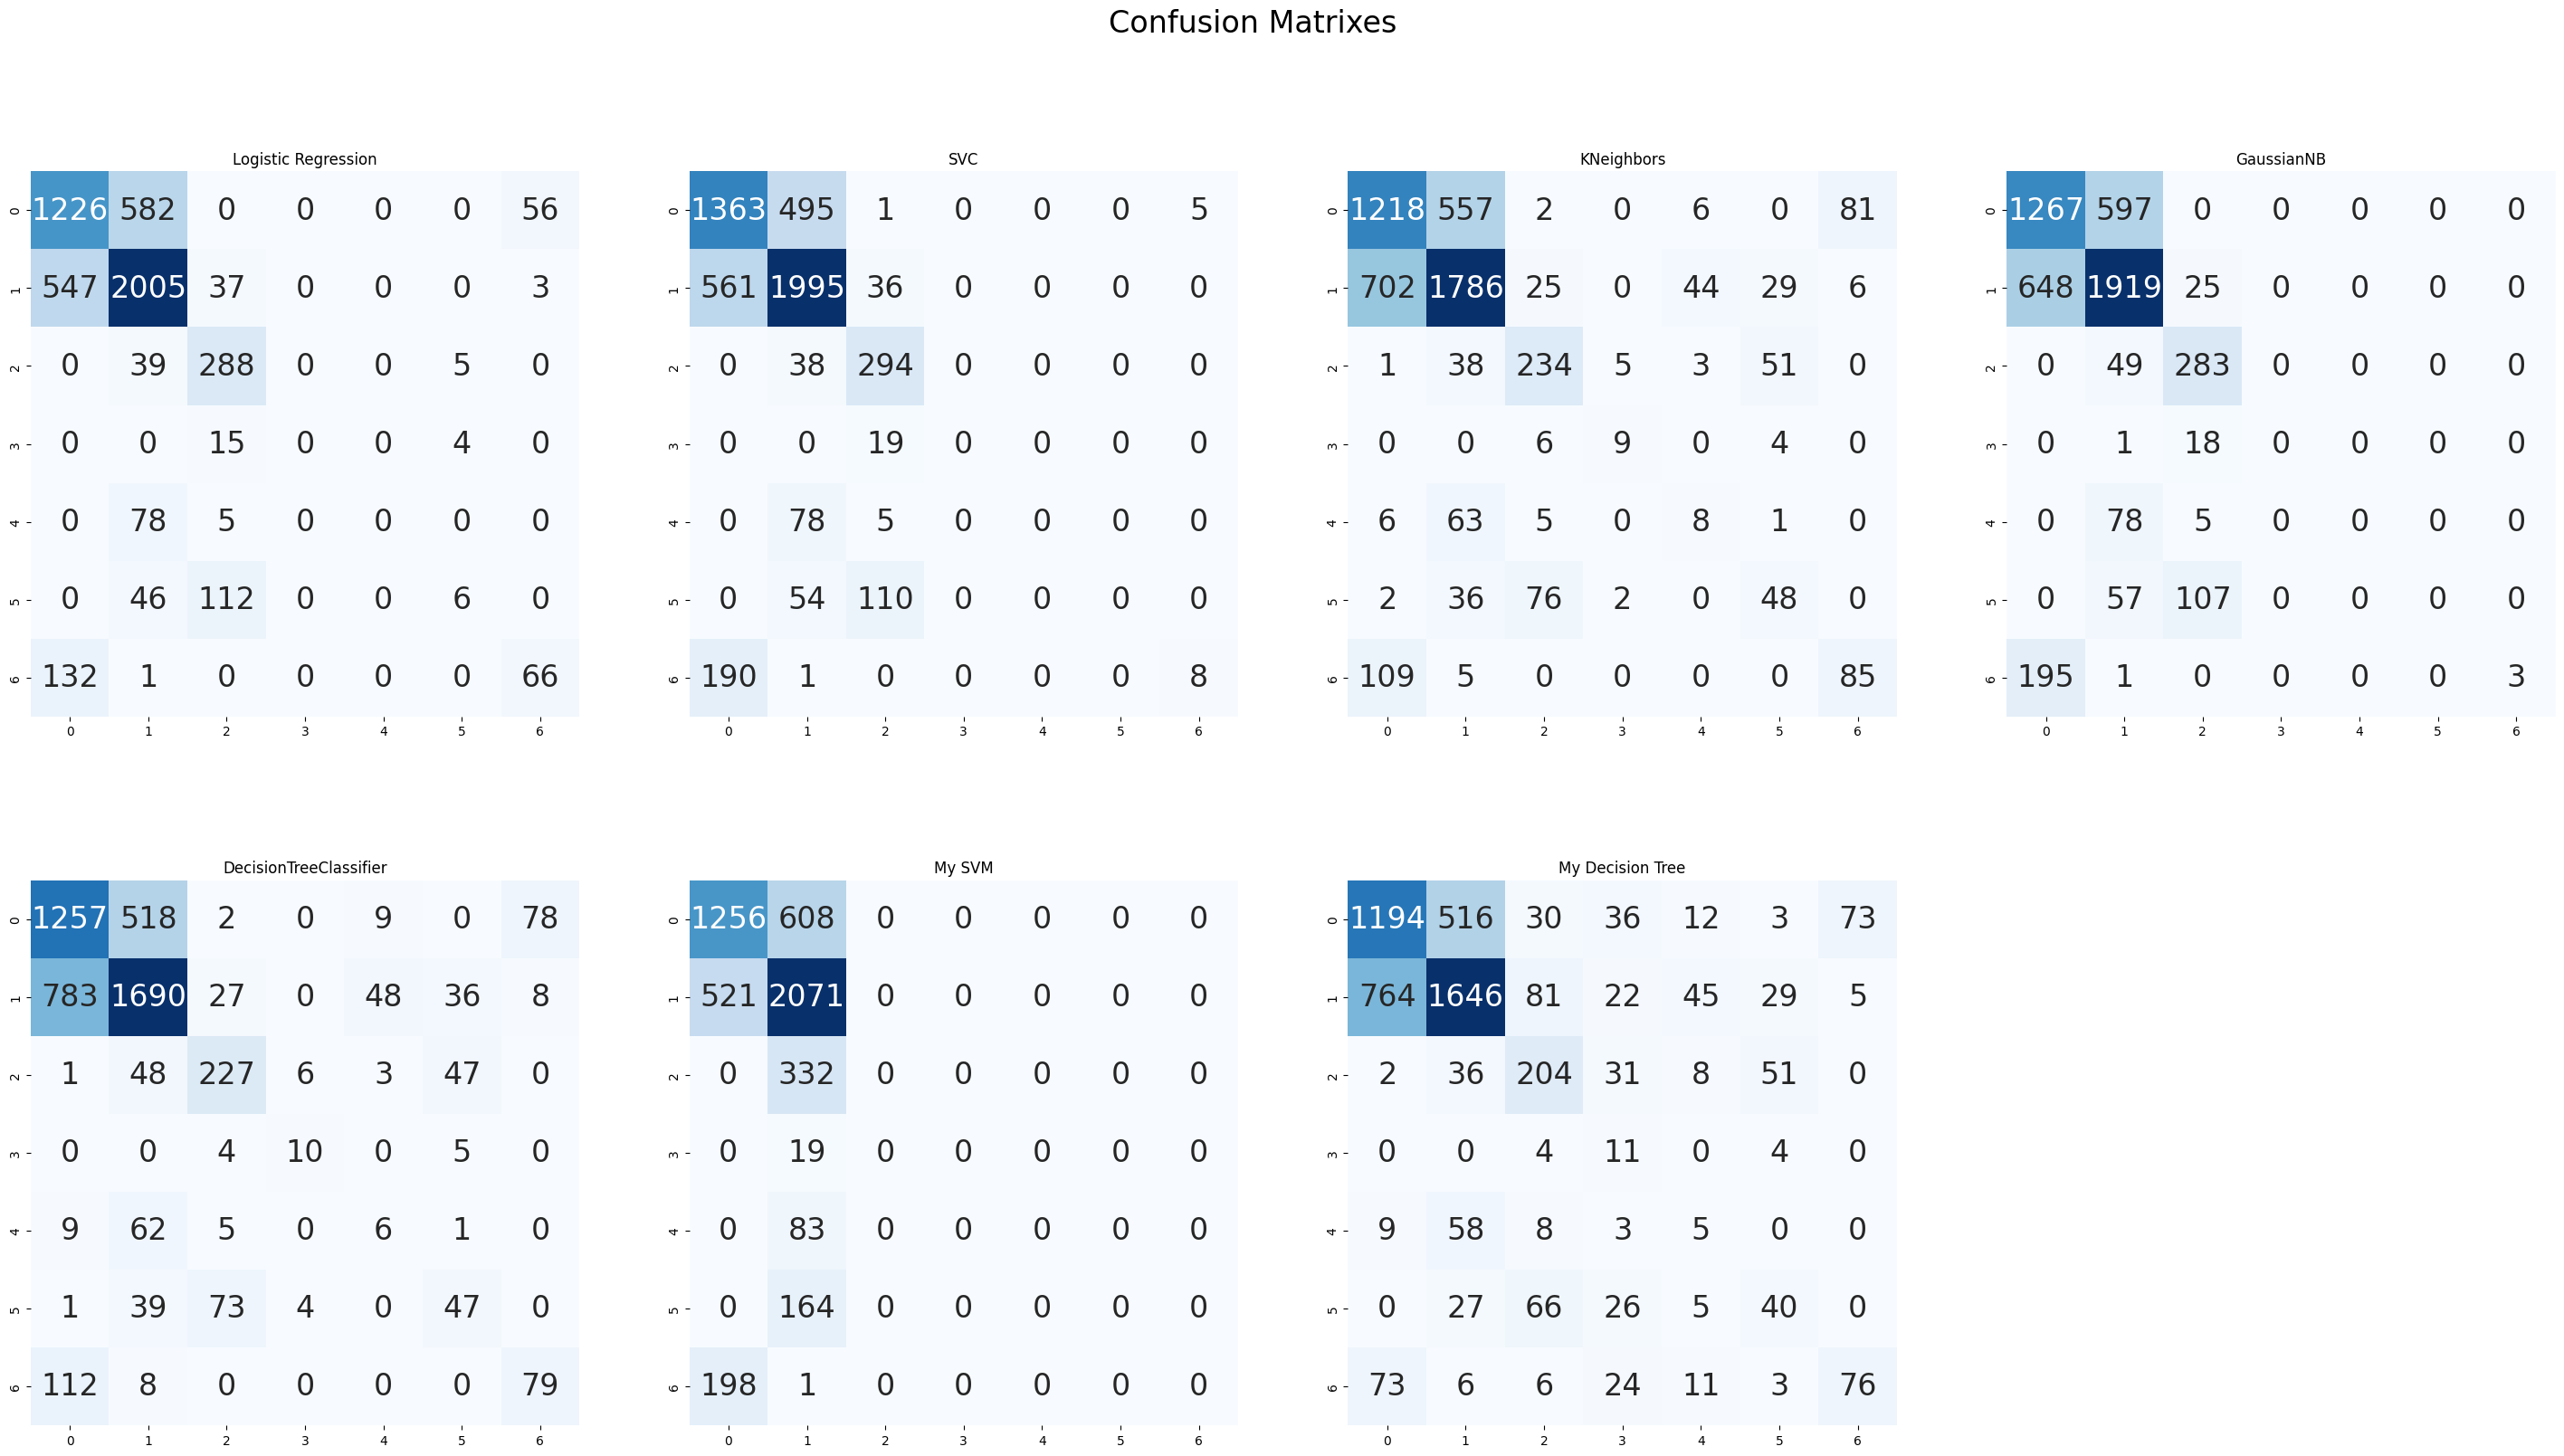

In [36]:
from sklearn.metrics import confusion_matrix

def get_cm(cl):
    return confusion_matrix(y_test, cl.predict(x_test.copy()))

plt.figure(figsize=(36, 18))
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.2, hspace= 0.3)


for idx, model_name in enumerate(trained_models):
    cm = get_cm(trained_models[model_name])
    plt.subplot(2, 4, idx+1)
    plt.title(model_name)
    sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Выводы


- Все модели показали примерно одинаковый результат
- В прошлом году на данном датасете ансамблевые алгоритмы классификации показали результаты сравнимые с результатами полученными в данной работе
